# PerformanceTest

In [1]:
import scipy.stats as sta
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,vectorize
from ipyparallel import Client
import random
import numpy
from pyhmc import hmc

## First Attempt: Basic Code

In [2]:
def SGHMC_friction(theta0, X, gradU, eps, sample_size, B, C, batch_size,burnin, M = None):
    '''
    SGHMC with friction. See details from Stochastic Gradient Hamiltonian Monte Carlo (Chen et al., 2014)
    
    INPUT:
    ----------------------------------------------------------------------
    theta0(1-dim numpy array): starting position of theta
    
    X(2-dims numpy array): data
    
    gradU(scale,theta,batch): function to compute gradient of U on a particular batch,
    
        INPUT:
        ----------------------------------------------------------------------
        scale: data size/ batch size
        theta: theta
        batch(numpy array): batch
        ----------------------------------------------------------------------
        OUTPUT:
        ----------------------------------------------------------------------
        thetat: Gradient of U on batch
        ----------------------------------------------------------------------
    
    eps: step size
    
    sample_size: number of samples drawn from prosterior distribution
    
    B: noise estimate
    
    C: user specified friction term
    
    batch_size: size of minibatches
    
    burnin: number of iterations for warm up
    
    M(optional): Mass matrix, defualt is set to be identity.
    ----------------------------------------------------------------------
    OUTPUT:
    ----------------------------------------------------------------------
    thetat: thetas sampled from posterior distribution
    ----------------------------------------------------------------------
    '''
    
    i = sample_size+burnin
    p = theta0.shape[0]
    thetat = np.zeros((i+1,p))
    thetat[0,:] = theta0
    
    m1 = int(np.ceil(X.shape[0]/batch_size))
    batch = [X[i::m1] for i in range(m1)]
    m = len(batch)

    if(M is None):
        M = np.eye(p)
    
    
    for t in range(i):
        ri = np.random.multivariate_normal(np.zeros(p), M)
        thetai = thetat[t]
        for j in range(m):
            thetai = thetai + eps * np.linalg.solve(M, ri)
            gU = gradU(X.shape[0]/batch[j].shape[0],thetai,batch[j])
            ri = ri - eps * gU - eps * C @ np.linalg.solve(M, ri) + np.random.multivariate_normal(np.zeros(p), np.array(2*eps*(C-B)).reshape(p,p))
        thetat[t+1] = thetai

    return thetat[burnin+1:]
        

## Test code and reproduce figure 1

In [3]:
def gradU(scale,theta,batch):
    
    def grad_log_data(x,theta):
        return -(-4*theta+4*theta**3)/50

    def grad_log_prior(theta):
        return 0
    return - scale*batch.shape[0]*grad_log_data(batch,theta)-grad_log_prior(theta)


In [4]:
@jit(nopython=True)
def gradU_numba(scale,theta,batch):
    return - scale*batch.shape[0]*(-(-4*theta+4*theta**3)/50)


In [5]:
%%timeit
SGHMC_friction(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU,
                eps=0.1,sample_size=10000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)

13.4 s ± 52.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
random.seed(100)
theta1 = SGHMC_friction(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU_numba,eps=0.1,sample_size=10000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)

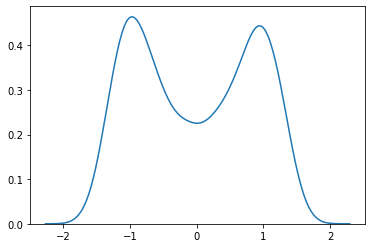

In [7]:
sns.kdeplot(np.concatenate(theta1).reshape(-1,))

## Example 2

In [8]:
mu = np.array([-5, 5]).reshape(2,1) # true value for mu
n = 200 # number of observations
y = np.r_[np.random.normal(mu[0], 1, n),np.random.normal(mu[1], 1, n)]

In [9]:
def gradU2(scale,theta,batch):
    def mn_glpdf(y,mu):
        exp1=numpy.exp(-0.5*(y-mu[0])**2)
        exp2=numpy.exp(-0.5*(y-mu[1])**2)

        v = numpy.c_[exp1*(y-mu[0]),exp2*(y-mu[1])]
        return numpy.sum(v/(exp1+exp2),axis=0)

    def mn_glpr(mu):
        return -(numpy.sum(mu)/100)
    return - scale*mn_glpdf(batch,theta)-mn_glpr(theta)

In [10]:
theta_mn = SGHMC_friction(theta0=np.array([1,1]), X = y[:,None], gradU = gradU2, eps=0.01, sample_size=1000, B=0, C=np.eye(2), batch_size=100,burnin=500)

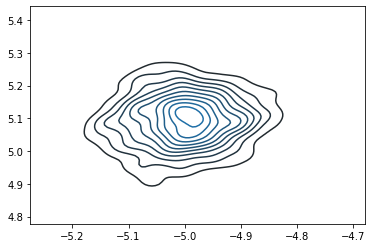

In [11]:
kdeplt2 = sns.kdeplot(theta_mn[:,0],theta_mn[:,1])  
plt.show()

## Profile Basic SGHMC function

In [12]:
profile = %prun -r -q SGHMC_friction(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU, eps=0.1,sample_size=2000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)
profile.sort_stats('cumtime').print_stats(10)

          2132514 function calls (2057514 primitive calls) in 6.383 seconds

   Ordered by: cumulative time
   List reduced from 73 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    6.383    6.383 {built-in method builtins.exec}
        1    0.000    0.000    6.383    6.383 <string>:1(<module>)
        1    0.461    0.461    6.383    6.383 <ipython-input-2-d7007b0f19ef>:1(SGHMC_friction)
    15000    0.629    0.000    4.115    0.000 {method 'multivariate_normal' of 'numpy.random.mtrand.RandomState' objects}
145000/70000    0.307    0.000    3.471    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    15000    0.039    0.000    2.094    0.000 <__array_function__ internals>:2(allclose)
    15000    0.063    0.000    2.015    0.000 numeric.py:2091(allclose)
    15000    0.035    0.000    1.701    0.000 <__array_function__ internals>:2(isclose)
    15000    0.179    0.000    1.

`np.multivariate_normal` appears to be slow

## Use SqrtM @ Normal to replace multivariate normal

In [13]:
def SGHMC_friction2(theta0, X, gradU, eps, sample_size, B, C, batch_size,burnin, M = None):
    '''
    SGHMC with friction:
    theta0(numpy array): starting position of theta
    X: data
    grad_logden_data: gradient of the data log density
    grad_logden_prior: gradient of the prior log density
    eps: step size
    sample_size: number of samples drawn from prosterior distribution
    B: noise estimate
    C: user specified friction term
    batch_size: size of minibatches
    M: Mass matrix
    '''
    
    i = sample_size+burnin
    p = theta0.shape[0]
    thetat = np.zeros((i+1,p))
    thetat[0] = theta0
    
    m1 = int(np.ceil(X.shape[0]/batch_size))
    batch = [X[i::m1] for i in range(m1)]
    m = len(batch)

    if(M is None):
        M = np.eye(p)
    
    M1sqrt = np.linalg.cholesky(M)
    Msqrt = np.linalg.cholesky(2*eps*(C-B))
    
    for t in range(i):
        thetai = thetat[t]
        ri = M1sqrt@np.random.normal(size=p)
        for j in range(m):
            thetai = thetai + eps * np.linalg.solve(M,ri)
            gU = gradU(X.shape[0]/batch[j].shape[0],thetai,batch[j])
            ri = ri - eps * gU - eps * C @ np.linalg.solve(M, ri) + Msqrt@np.random.normal(size=p)
        thetat[t+1] = thetai
    
    return thetat[burnin+1:]
        

## Test SGHMC2

In [14]:
%%timeit
SGHMC_friction2(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU, eps=0.1,sample_size=10000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)

3.1 s ± 52.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
random.seed(100)
theta1 = SGHMC_friction2(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU_numba, eps=0.1,sample_size=10000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)

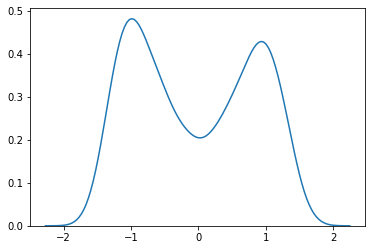

In [16]:
sns.kdeplot(theta1.reshape(-1,))

In [17]:
theta_mn = SGHMC_friction2(theta0=np.array([1,1]), X = y[:,None], gradU = gradU2, eps=0.01, sample_size=1000, B=0, C=np.eye(2), batch_size=100,burnin=500)

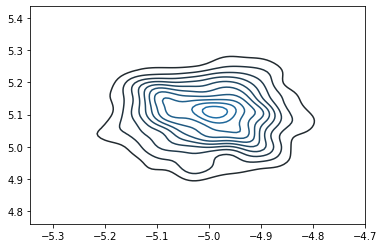

In [18]:
kdeplt2 = sns.kdeplot(theta_mn[:,0],theta_mn[:,1])  
plt.show()

## Profile SGHMC2

In [19]:
profile = %prun -r -q SGHMC_friction2(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU, eps=0.1,sample_size=2000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)
profile.sort_stats('cumtime').print_stats(10)

          802556 function calls in 1.789 seconds

   Ordered by: cumulative time
   List reduced from 33 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.789    1.789 {built-in method builtins.exec}
        1    0.000    0.000    1.789    1.789 <string>:1(<module>)
        1    0.255    0.255    1.789    1.789 <ipython-input-13-cde73ae1588d>:1(SGHMC_friction2)
    25000    0.055    0.000    1.174    0.000 <__array_function__ internals>:2(solve)
    25002    0.044    0.000    1.105    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    25000    0.305    0.000    1.061    0.000 linalg.py:323(solve)
    25002    0.144    0.000    0.346    0.000 linalg.py:144(_commonType)
    12500    0.079    0.000    0.227    0.000 <ipython-input-3-876c899523f9>:1(gradU)
    50002    0.104    0.000    0.227    0.000 linalg.py:116(_makearray)
    12500    0.140    0.000    0.140    0.000 <i

## GradU seems to be slow

Implement numba version gradU

In [20]:
%%timeit
SGHMC_friction2(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU_numba, eps=0.1,sample_size=10000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)

2.4 s ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Use parallel computation to futher reduce running time

In [21]:
def parallel_setup(view):
    with view.sync_imports():
        import numpy

In [22]:
def SGHMC_parallel(theta0, X, gradU, eps, sample_size, B, C, batch_size,burnin, M = None):
    '''
    parallel version of SGHMC. Please set ipython Clusters before running the following code.
    
    SETUP:
    ----------------------------------------------------------------------
    Step1:
    Open a terminal (cmd.exe) and type:
    ipcluster start -n 4(or other specified number of engines)
    
    Step2: 
    Run the following code 
    
    from ipyparallel import Client
    rc = Client()
    dv = rc[:]
    n = len(rc.ids)
    with dv.sync_imports():
        import numpy
    
    dv.push(dict(gradU=gradU))
    
        
    INPUT:
    ----------------------------------------------------------------------
    theta0: starting position of theta
    
    X: data
    
    grad_logden_data: gradient of the data log density
    
    grad_logden_prior: gradient of the prior log density
    
    eps: step size
    
    sample_size: number of samples drawn from prosterior distribution
    
    B: noise estimate
    
    C: user specified friction term
    
    batch_size: size of minibatches
    
    burnin: number of iterations for warm up
    
    M(optional): Mass matrix, defualt is set to be identity.
    ----------------------------------------------------------------------
    OUTPUT:
    
    thetat: thetas sampled from posterior distribution
    ----------------------------------------------------------------------
    '''
    from ipyparallel import Client
    rc = Client()
    dv = rc[:]
    n = len(rc.ids)
    parallel_setup(dv)
    
    dv.push(dict(gradU=gradU))
    i = int((sample_size+n*burnin)/4)  

    @dv.remote(block=True)
    def SGHMC_friction4(theta0, X, gradU, eps, sample_size, B, C, batch_size,burnin, M = None):

        i = sample_size+burnin
        p = theta0.shape[0]
        thetat = numpy.zeros((i+1,p))
        thetat[0] = theta0

        m1 = int(numpy.ceil(X.shape[0]/batch_size))
        batch = [X[i::m1] for i in range(m1)]
        m = len(batch)

        if(M is None):
            M = numpy.eye(p)

        M1sqrt = numpy.linalg.cholesky(M)
        Msqrt = numpy.linalg.cholesky(2*eps*(C-B))

        for t in range(i):
            thetai = thetat[t]
            ri = M1sqrt@numpy.random.normal(size=p)
            for j in range(m):
                thetai = thetai + eps * numpy.linalg.solve(M,ri)
                gU = gradU(X.shape[0]/batch[j].shape[0],thetai,batch[j])
                ri = ri - eps * gU - eps * C @ numpy.linalg.solve(M, ri) + Msqrt@numpy.random.normal(size=p)
            thetat[t+1] = thetai

        return thetat[burnin+1:]
    
    theta = SGHMC_friction4(theta0, X, gradU, eps, i, B, C, batch_size,burnin, M)
    return numpy.concatenate(theta)

In [23]:
%%timeit
SGHMC_parallel(np.array([0]),np.zeros((50,1)),gradU,0.1,10000, np.array([0]),2*np.eye(1),10,500)

importing numpy on engine(s)
importing numpy on engine(s)
importing numpy on engine(s)
importing numpy on engine(s)
importing numpy on engine(s)
importing numpy on engine(s)
importing numpy on engine(s)
importing numpy on engine(s)
1.25 s ± 85.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
theta1 = SGHMC_parallel(np.array([0]),np.zeros((50,1)),gradU_numba,0.1,10000, np.array([0]),2*np.eye(1),10,500)

importing numpy on engine(s)
importing numpy on engine(s)
importing numpy on engine(s)
importing numpy on engine(s)
importing numpy on engine(s)
importing numpy on engine(s)
importing numpy on engine(s)
importing numpy on engine(s)
1.19 s ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
theta1 = SGHMC_parallel(np.array([0]),np.zeros((50,1)),gradU_numba,0.1,10000, np.array([0]),2*np.eye(1),10,500)

importing numpy on engine(s)


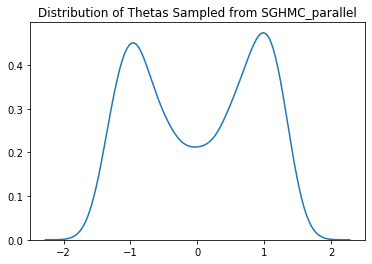

In [26]:
plot_sghmc = sns.kdeplot(theta1[:,0])
plot_sghmc.set_title("Distribution of Thetas Sampled from SGHMC_parallel")
fig1 = plot_sghmc.get_figure()
fig1.savefig("plot_sghmc.png")

In [27]:
random.seed(100)
theta_mn = SGHMC_parallel(theta0=np.array([1,1]), X = y[:,None], gradU = gradU2, eps=0.01, sample_size=5000, B=0, C=np.eye(2), batch_size=100,burnin=500)

importing numpy on engine(s)


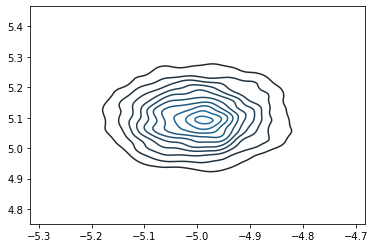

In [28]:
kdeplt2 = sns.kdeplot(theta_mn[:,0],theta_mn[:,1])  
plt.show()

# real distribution

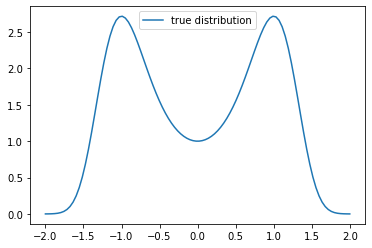

In [29]:
theta = np.linspace(-2,2,100)
p = np.exp(2*theta**2-theta**4)
fig, ax = plt.subplots()
ax.plot(theta,p,label = "true distribution")
ax.legend(loc= "upper center")

## Pyhmc

In [30]:
def logprob(theta):
    log = 2* theta**2 -theta**4 
    grad = 4*theta-4*theta**3
    return log, grad

In [31]:
%%time
theta0 = np.array([0])
samples = hmc(logprob, x0=theta0, n_samples=10000)

CPU times: user 336 ms, sys: 208 ms, total: 544 ms
Wall time: 473 ms


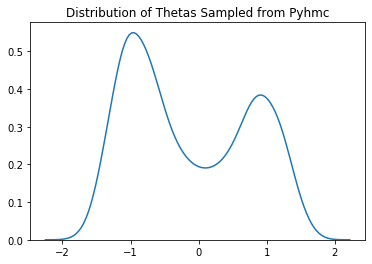

In [32]:
plot_pyhmc = sns.kdeplot(samples[:,0])
plot_pyhmc.set_title("Distribution of Thetas Sampled from Pyhmc")
fig1 = plot_pyhmc.get_figure()
fig1.savefig("plot_pyhmc.png")

## PyStan

In [33]:
import pystan

In [34]:
%%time
model = """
functions {
    real p_lpdf(real theta) {return 2*theta^2-theta^4;}
}
parameters {
    real theta;
}
model {
    theta ~ p_lpdf();
}
"""
data = {}

fit = pystan.stan(model_code=model, data=data, iter=1000, chains=1)
theta = fit.extract(permuted=True)['theta']

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_131ecaec6df280621883c2ade2313a62 NOW.


CPU times: user 1.38 s, sys: 164 ms, total: 1.55 s
Wall time: 1min 13s


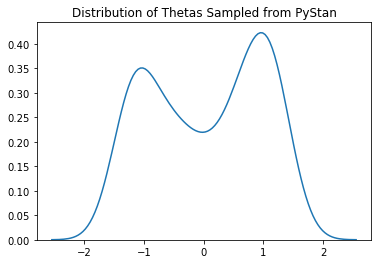

In [35]:
plot_pystan = sns.kdeplot(theta)
plot_pystan.set_title("Distribution of Thetas Sampled from PyStan")
fig1 = plot_pystan.get_figure()
fig1.savefig("plot_pyStan.png")